Ejecutar el notebook completo

# Estrategia General

1. Preprocesamiento de los nodos y aristas
2. Propagación de mensaje basado en algoritmo (Map) \\
    `[(node, property), ... ]`
3. Procesamiento de las respuestas (Reduce) \\
    `[(node, result), ... ]`
4. Actualización de las propiedades del algoritmo
5. Evaluación de condición de término del algoritmo


# Imports

In [1]:
!pip install pyspark
!pip install pyvis

In [2]:
from pyspark.sql import Row
from pyspark.sql.functions import col, row_number, max
from pyspark.sql.window import Window

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyvis.network import Network
import numpy as np
from random import randint

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Create Random Graphs

In [4]:
def buildAdjList(nodes, edges):
  g = {}
  for node in nodes:
    g[node] = []
  for edge in edges:
    g[edge[0]].append(edge[1])
  return g

In [5]:
def plotGraph(G, node_size=50, arrow_size=15, line_thickness=0.2, names=False):
  # pos = nx.spring_layout(G)
  pos = nx.spring_layout(G, k=1, iterations=20)
  nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')
  nx.draw_networkx_nodes(G, pos, node_size=node_size)
  nx.draw_networkx_edges(G, pos, width=line_thickness, arrowsize=arrow_size, node_size=node_size)
  plt.title('Grafo de Generado')
  plt.show()

In [6]:
# Para Grafos Grandes se recomienta no plottear el grafo ya que toma demasiado tiempo (plot=False)
def createRandomGraph(n_nodes, prob_edge=0.5, directed=True, plot = True):
  G = nx.fast_gnp_random_graph(n_nodes, prob_edge, 42, True)
  if (plot):
    plotGraph(G, node_size=200)
  return G

In [7]:
# Acá podria haber obtenido directamente la lista de adyacencia
# pero preferí obtener el input de datos descrito en el enunciado
def createRepresentation(G):
  edges = nx.to_edgelist(G)
  edges = [(i[0], i[1]) for i in edges]
  return list(G.nodes), edges

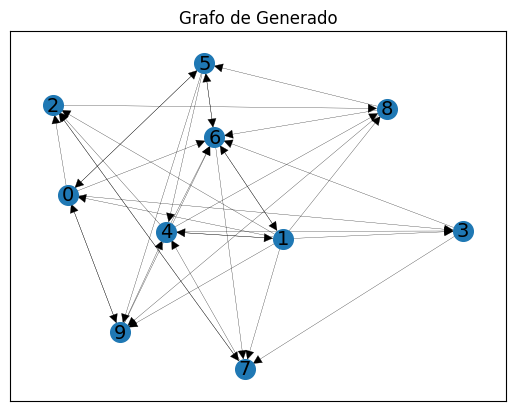

In [8]:
G = createRandomGraph(10, 0.4)

In [9]:
nodes, edges = createRepresentation(G)

In [10]:
print('Representacion definida en el doc')
print(f'nodes({len(nodes)}):  {nodes}\nedges ({len(edges)}): {edges}')

Representacion definida en el doc
nodes(10):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
edges (37): [(0, 2), (0, 3), (0, 5), (0, 6), (0, 9), (1, 2), (1, 3), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (1, 0), (2, 7), (2, 8), (3, 6), (3, 7), (4, 6), (4, 8), (4, 1), (4, 2), (4, 3), (5, 6), (5, 9), (5, 0), (5, 4), (6, 7), (6, 1), (6, 5), (7, 2), (7, 4), (8, 9), (8, 5), (8, 6), (9, 0), (9, 4), (9, 6)]


In [11]:
adj = buildAdjList(nodes, edges)
print('Lista de adyacencia')
print(adj)

Lista de adyacencia
{0: [2, 3, 5, 6, 9], 1: [2, 3, 4, 6, 7, 8, 9, 0], 2: [7, 8], 3: [6, 7], 4: [6, 8, 1, 2, 3], 5: [6, 9, 0, 4], 6: [7, 1, 5], 7: [2, 4], 8: [9, 5, 6], 9: [0, 4, 6]}


# Page Rank

In [12]:
def initRDDPageRank(nodes):
  n = len(nodes)
  data = [(node, 1/n) for node in nodes]
  return sc.parallelize(data)

In [13]:
def propagatePageRank(node):
  propagation = []
  n_neigh = len(adj[node[0]])
  val_propagated = (node[1]/n_neigh) if n_neigh > 0 else 0
  for neigh in adj[node[0]]:
    propagation.append((neigh, val_propagated))
  return propagation

In [14]:
def reducePropagation(rdd):
  flatten = rdd.flatMap(lambda x: x)
  return flatten.reduceByKey(lambda a,b: a+b)

In [15]:
def applyDamping(node, dampling, dampling_factor):
  return (node[0], (node[1]*dampling)+dampling_factor)

In [16]:
def pageRank(rdd, n_iter, dampling=0.85):
  dampling_factor = (1-dampling)/len(nodes) if len(nodes) > 0 else 0
  for _ in range(n_iter):
    propagated = rdd.map(propagatePageRank)
    reduced = reducePropagation(propagated)
    rdd = reduced.map(lambda node: applyDamping(node, dampling, dampling_factor))
    print(rdd.collect())
  return rdd

In [17]:
rdd = initRDDPageRank(nodes)

In [18]:
%%time
pr = pageRank(rdd, 10)

[(4, 0.11770833333333335), (8, 0.085125), (0, 0.07520833333333334), (5, 0.08866666666666667), (9, 0.09220833333333334), (1, 0.060333333333333336), (2, 0.10212500000000001), (6, 0.18004166666666666), (3, 0.05962500000000001), (7, 0.13895833333333335)]
[(8, 0.08482395833333334), (0, 0.06637777777777779), (4, 0.12543506944444446), (1, 0.08602222222222221), (9, 0.07715625), (5, 0.10291597222222222), (6, 0.14863298611111112), (2, 0.11326354166666668), (3, 0.05420625000000001), (7, 0.14116597222222224)]
[(8, 0.09360082812500001), (4, 0.1278659809027778), (0, 0.06787044270833333), (9, 0.08132718229166666), (5, 0.09243035648148148), (1, 0.07843664120370371), (6, 0.14754973784722225), (2, 0.11674358333333335), (3, 0.0567480451388889), (7, 0.13742720196759262)]
[(8, 0.09468713279803241), (0, 0.06601804552951389), (4, 0.12442460636574074), (9, 0.08103355377604167), (5, 0.0948639689525463), (1, 0.0785429758101852), (6, 0.14993139136284725), (2, 0.11501564597800927), (3, 0.05660908514178241), (7, 0

In [19]:
pr_results = pr.collect()
pr_results

[(8, 0.09351595724661133),
 (0, 0.06667380137450873),
 (4, 0.12548668382322656),
 (9, 0.08143007135794841),
 (5, 0.09522668599964935),
 (1, 0.0787356674383845),
 (6, 0.14965010254303965),
 (2, 0.11485160337599082),
 (3, 0.05603872092727301),
 (7, 0.13839070591336772)]

In [20]:
hash_results = {}
for node, pr_node in pr_results:
  hash_results[node] = pr_node
hash_results

{8: 0.09351595724661133,
 0: 0.06667380137450873,
 4: 0.12548668382322656,
 9: 0.08143007135794841,
 5: 0.09522668599964935,
 1: 0.0787356674383845,
 6: 0.14965010254303965,
 2: 0.11485160337599082,
 3: 0.05603872092727301,
 7: 0.13839070591336772}

In [21]:
adj_pr = {}
for node, pr_node in pr_results:
  adj_pr[f'{node}\n{round(pr_node, 2)}'] = [ f'{n}\n{round(hash_results[n], 2)}' for n in adj[node]]
adj_pr

{'8\n0.09': ['9\n0.08', '5\n0.1', '6\n0.15'],
 '0\n0.07': ['2\n0.11', '3\n0.06', '5\n0.1', '6\n0.15', '9\n0.08'],
 '4\n0.13': ['6\n0.15', '8\n0.09', '1\n0.08', '2\n0.11', '3\n0.06'],
 '9\n0.08': ['0\n0.07', '4\n0.13', '6\n0.15'],
 '5\n0.1': ['6\n0.15', '9\n0.08', '0\n0.07', '4\n0.13'],
 '1\n0.08': ['2\n0.11',
  '3\n0.06',
  '4\n0.13',
  '6\n0.15',
  '7\n0.14',
  '8\n0.09',
  '9\n0.08',
  '0\n0.07'],
 '6\n0.15': ['7\n0.14', '1\n0.08', '5\n0.1'],
 '2\n0.11': ['7\n0.14', '8\n0.09'],
 '3\n0.06': ['6\n0.15', '7\n0.14'],
 '7\n0.14': ['2\n0.11', '4\n0.13']}

In [22]:
graph_pr = nx.from_dict_of_lists(adj_pr)

In [23]:
nodes_pr, edges_pr = createRepresentation(graph_pr)

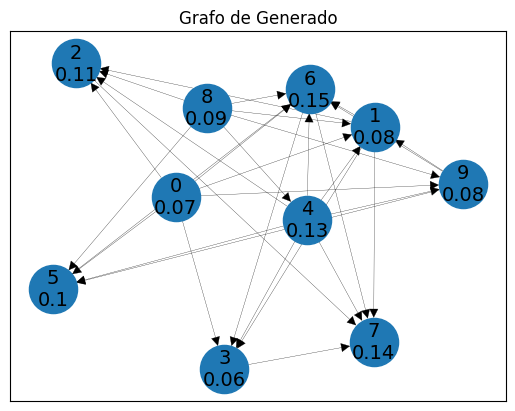

In [24]:
G_pr = nx.DiGraph()
G_pr.add_edges_from(edges_pr)
plotGraph(G_pr, node_size=1200)